In [25]:
# Load in PyTorch's pretrained network
import numpy as np
import os
import torchvision.models as models
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn.functional as func
import pandas as pd
from torch.utils.data.dataset import Dataset
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from random import shuffle
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [ ]:
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [26]:
class CHXData(Dataset):
    def __init__(self, img_dir, path_to_labels, is_trainset):
        self.img_dir = img_dir
        self.data_df = pd.read_csv(path_to_labels)
        self.img_names = self.data_df['Image Index']
        self.labels = np.asarray(self.data_df.loc[:, self.data_df.columns != 'Image Index'])
        
        # Normalization and data augmentation
        self.train_transforms = transforms.Compose([
            transforms.Resize(1024),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.CenterCrop(800),
            transforms.ToTensor(),
            # Normalize by using pre-computed dataset statistics
            transforms.Normalize((0.4901, 0.4901, 0.4901), (0.230188, 0.230188, 0.230188))
        ])
        self.test_transforms = transforms.Compose([
            transforms.Resize(1024),
            transforms.ToTensor(),
            transforms.Normalize((0.4901, 0.4901, 0.4901), (0.230188, 0.230188, 0.230188))
        ])
        self.is_train = is_trainset
        
    # Return size of the dataset
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        # Converts to 3-Channel as Resnet takes in 3 channels
        if self.is_train:
            image = self.train_transforms(Image.open(img_path).convert('RGB'))
        else:
            image = self.test_transforms(Image.open(img_path).convert('RGB'))
        label = self.labels[idx]
        return (image, label)

In [27]:
# Define paths to data
path_to_train_data = './data/Train/'
path_to_test_data = './data/Test/'
path_to_val_data = './data/Val'
path_to_test_labels = './data/Labels/Test_Labels.csv'
path_to_train_labels = './data/Labels/Train_Labels.csv'
path_to_val_labels='./data/Labels/Val_Labels.csv'

In [28]:
# Create dataset and data loader
test_dataset = CHXData(path_to_test_data, path_to_test_labels, False)
train_dataset = CHXData(path_to_train_data, path_to_train_labels, True)
val_dataset =  CHXData(path_to_val_data, path_to_val_labels, False)

# More num_workers consumes more memory for good for speeding up I/O
# pin_memory=True enables fast data transfer to GPUs
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=4)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=4)

In [29]:
# Source: https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=1.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, model_output, target):
        BCE_loss = func.binary_cross_entropy_with_logits(model_output, target)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss

In [38]:
class CHXModel():
    def __init__(self):
        self.model = None
        self.losses = None
        self.optimizer = None
        self.model_losses = None
    
    # Freeze or un-freeze model layers as required
    def update_grad(self, grad_val):
        for param in self.model.parameters():
            param.requires_grad = grad_val
            
    # Initial model setup
    def set_up_model(self, n_classes, lr, unfreeze, pretrained, use_focal, gamma=1.0, alpha=0.25):
        self.model = models.resnet34(pretrained=pretrained, progress=True)
        # Freeze all layers
        self.update_grad(unfreeze)
        # Resnet has one fully connected layer, which outputs dimensions of n_classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, n_classes)
        self.model.cuda()
        # Use a binary cross-entropy loss function; Applies sigmoid internally (generating probabilities)
        # On the probabilities, cross-entropy loss is computed
        # Because we are doing multilabel, this is better as the value outtputted (unlike softmax)
        # is independent of the other values (while in softmax, probabilities must add up to one)
        if use_focal:
            self.losses = FocalLoss(gamma, alpha)
            print(f'Using Focal Loss: {gamma}, {alpha}')
        else:
            # Regular binary cross entropy
            self.losses = torch.nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
    
    def load_checkpoint(self, file_path):
        checkpoint = torch.load(file_path)
        self.model.load_state_dict(checkpoint['state'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        return checkpoint['epoch']

    def save_checkpoint(self, state, filename):
        torch.save(state, filename)      
    
    def evaluate(self, data_loader, is_validation=True):
        average_loss = 0
        average_auc = 0
        with torch.no_grad():
            # Go through each batch in the testloader
            for X, y in data_loader:
                input_img = X.cuda(non_blocking=True)
                labels = y.float().cuda(non_blocking=True)
                self.optimizer.zero_grad()
                output = self.model(input_img)
                sig = torch.nn.Sigmoid()
                probabilities = sig(output)
                predictions = probabilities >= 0.30
                # Push data to CPU first
                y = y.cpu()
                predictions = np.array(predictions.cpu()).astype(int)
                probabilities = np.array(probabilities.cpu())
                for i in range(len(y)):
                    if sum(predictions[i,:]) == 0:
                            max_idx = np.where(probabilities[i,:]==max(probabilities[i,:]))
                            predictions[i, max_idx] = 1
                    cur_loss = sk_metrics.hamming_loss(y[i,:], predictions[i,:])
                    auc = sk_metrics.roc_auc_score(y[i,:], probabilities[i,:], average='micro')
                    average_loss += cur_loss
                    average_auc += auc
        if is_validation:
            total = len(val_dataset)
        else:
            total = len(test_dataset)
        average_loss = average_loss/total
        average_auc = average_auc/total
        return average_auc, average_loss
        

    def train(self, epochs, trainloader, val_loader=None, checkpoint_path=None, root_path=None):
        # Empty cache before training
        torch.cuda.empty_cache()
        curr_auc = 1000
        if checkpoint_path != None:
            start_epoch = self.load_checkpoint(checkpoint_path)
        else:
            start_epoch = 0
        for e in range(start_epoch, epochs):
            # Get loss per epoch
            running_loss = 0
            for i, (X, y) in enumerate(trainloader):
                input_img = X.cuda(non_blocking=True)
                labels = y.float().cuda(non_blocking=True)
                self.optimizer.zero_grad()
                output = self.model(input_img)
                loss = self.losses(output, labels)
                loss.backward()
                self.optimizer.step()
                running_loss = running_loss + loss.item()
            
            # Stop training if validation auc score is now dropping
            if val_loader != None:
                average_auc, average_loss = self.evaluate(val_loader)
                if average_auc > curr_auc:
                    break
            
            # Find the loss for the current epoch
            loss = running_loss/len(trainloader)
            print(f"Epoch {e + 1} - Loss: {loss}")
            # Save model losses so far so we can plot them if we stop half way?
            state = {
                'epoch': e + 1,
                'state': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict()
            }
            if root_path == None:
                root_path = './checkpoints/checkpoint_epoch_'
            checkpoint_path = os.path.join(root_path + str(e + 1) + '.pth.tar') 
            self.save_checkpoint(state, checkpoint_path)
            

In [40]:
classes = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation']

def plot_images(img, predictions, correctlabel):
        plt.figure(num=None, figsize=(8, 6))
        plt.imshow(img[0,:,:], cmap='gray')
        correct_labels = [classes[idx] for (idx, val) in enumerate(correctlabel) if val == 1]
        
        preds = [classes[idx] for (idx, val) in enumerate(predictions) if val == True]
        correct_labels = ", ".join(correct_labels)
        preds = ", ".join(preds)
        print(f'Correct Labels: {correct_labels}')
        print(f'Predicted Labels: {preds}')
        plt.show()

to_plot = 20
def get_images(cur_model):
    cor_count = 0
    incor_count = 0
    with torch.no_grad():
        # Go through each batch in the testloader
        for X, y in test_loader:
            input_img = X.cuda(non_blocking=True)
            labels = y.float().cuda(non_blocking=True)
            cur_model.optimizer.zero_grad()
            output = cur_model.model(input_img)
            sig = torch.nn.Sigmoid()
            probabilities = sig(output)
            predictions = probabilities >= 0.30
            y = y.cpu()
            predictions = np.array(predictions.cpu()).astype(int)
            probabilities = np.array(probabilities.cpu())
            for i in range(len(y)): 
                if sum(predictions[i,:]) == 0:
                    max_idx = np.where(probabilities[i,:]==max(probabilities[i,:]))
                    predictions[i, max_idx] = 1
                cur_loss = sk_metrics.hamming_loss(y[i,:], predictions[i,:])
                if cur_loss == 0.0 and cor_count < to_plot:
                    plot_images(input_img[i].cpu(), predictions[i,:], y[i,:])
                    cor_count += 1
                elif cur_loss > 0.0 and incor_count < to_plot:
                    plot_images(input_img[i].cpu(), predictions[i,:], y[i,:])
                    incor_count += 1

## Training pretrained ResNet34 using BCE

In [5]:
n_classes = 14
learning_rate = 1e-4
chx_model = CHXModel()
chx_model.set_up_model(n_classes, learning_rate, unfreeze=False, pretrained=True, use_focal=False)

In [9]:
chx_model.train(5, train_loader)

Epoch 1 - Loss: 0.3085582232858548
Epoch 2 - Loss: 0.2966509884153131
Epoch 3 - Loss: 0.29403893687574406
Epoch 4 - Loss: 0.2922991756225901
Epoch 5 - Loss: 0.29103734461536956


In [14]:
torch.cuda.empty_cache()

In [8]:
n_classes = 14
learning_rate = 1e-4
chx_model_uf = CHXModel()
chx_model_uf.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=True, use_focal=False)
path_to_model = './checkpoints/checkpoint_epoch_5.pth.tar'
chx_model_uf.train(15, train_loader, root_path='./checkpoints_unfreeze/checkpoint_epoch_', checkpoint_path=path_to_model, val_loader=val_loader)

Epoch 6 - Loss: 0.270049540897951
Epoch 7 - Loss: 0.255652468197939
Epoch 8 - Loss: 0.25059833045669344
Epoch 9 - Loss: 0.2470375784733298
Epoch 10 - Loss: 0.2435439411136839
Epoch 11 - Loss: 0.24035446798077786
Epoch 12 - Loss: 0.23746641206644
Epoch 13 - Loss: 0.23424581944794362
Epoch 14 - Loss: 0.23178980064425944


## Pretrained Network Using Focal Loss

In [9]:
n_classes = 14
learning_rate = 1e-4
chx_model_focal = CHXModel()
chx_model_focal.set_up_model(n_classes, learning_rate, unfreeze=False, pretrained=True, use_focal=True)
chx_model_focal.train(5, train_loader, root_path='./checkpoints_focal/checkpoint_epoch_')

Epoch 1 - Loss: 0.022315427138492827
Epoch 2 - Loss: 0.01935367576546653
Epoch 3 - Loss: 0.019006049628070083
Epoch 4 - Loss: 0.01874462779850891
Epoch 5 - Loss: 0.018566741547165252


In [8]:
n_classes = 14
learning_rate = 1e-4
chx_model_focal_unfreeze = CHXModel()
chx_model_focal_unfreeze.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=True, use_focal=True)
path_to_model = './checkpoints_focal/checkpoint_epoch_5.pth.tar'
chx_model_focal_unfreeze.train(10, train_loader, root_path='./checkpoints_focal_unfreeze/checkpoint_epoch_', checkpoint_path=path_to_model, val_loader=val_loader)

Epoch 6 - Loss: 0.016218932244508804
Epoch 7 - Loss: 0.01471392229565723
Epoch 8 - Loss: 0.014141751618088508
Epoch 9 - Loss: 0.01369372366494137
Epoch 10 - Loss: 0.013370855709416861


In [10]:
n_classes = 14
learning_rate = 1e-4
chx_model_focal_unfreeze = CHXModel()
chx_model_focal_unfreeze.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=True, use_focal=True)
path_to_model = './checkpoints_focal_unfreeze/checkpoint_epoch_10.pth.tar'
chx_model_focal_unfreeze.train(15, train_loader, root_path='./checkpoints_focal_unfreeze_continue/checkpoint_epoch_', checkpoint_path=path_to_model, val_loader=val_loader)

Epoch 11 - Loss: 0.013062908017613128
Epoch 12 - Loss: 0.012746935993311335
Epoch 13 - Loss: 0.012488429810168115
Epoch 14 - Loss: 0.012268691452304057
Epoch 15 - Loss: 0.011965583738539318


## Training a model with random initialization and BCE

In [10]:
n_classes = 14
learning_rate = 1e-4
chx_model_random = CHXModel()
chx_model_random.set_up_model(n_classes, learning_rate, unfreeze=False, pretrained=False, use_focal=False)
chx_model_random.train(5, train_loader, root_path='./checkpoints_random/checkpoint_epoch_')

Epoch 1 - Loss: 0.3255094151340937
Epoch 2 - Loss: 0.30462074473070727
Epoch 3 - Loss: 0.3024236468841919
Epoch 4 - Loss: 0.3014811743587718
Epoch 5 - Loss: 0.30055508448715484


In [10]:
n_classes = 14
learning_rate = 1e-4
chx_model_random_unfreeze = CHXModel()
chx_model_random_unfreeze.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=False, use_focal=False)
path_to_model = './checkpoints_random/checkpoint_epoch_5.pth.tar'
chx_model_random_unfreeze.train(10, train_loader, root_path='./checkpoints_random/checkpoint_epoch_', checkpoint_path=path_to_model, val_loader=val_loader)

Epoch 6 - Loss: 0.2965115940672394
Epoch 7 - Loss: 0.2912565004933502
Epoch 8 - Loss: 0.28878421771492485
Epoch 9 - Loss: 0.2865698926989221
Epoch 10 - Loss: 0.2837515783978558


In [10]:
n_classes = 14
learning_rate = 1e-4
chx_model_random_unfreeze = CHXModel()
chx_model_random_unfreeze.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=False, use_focal=False)
path_to_model = './checkpoints_random/checkpoint_epoch_10.pth.tar'
chx_model_random_unfreeze.train(15, train_loader, root_path='./checkpoints_random/checkpoint_epoch_', checkpoint_path=path_to_model, val_loader=val_loader)

Epoch 11 - Loss: 0.2804080172024342
Epoch 12 - Loss: 0.27671833950490615
Epoch 13 - Loss: 0.2730224155283668
Epoch 14 - Loss: 0.26961825900692277
Epoch 15 - Loss: 0.266983476727619


## Try a stronger focal loss

In [9]:
# Use a gamma value of 2.5 while previously, gamma=1 was used (higher gamma does what?)
# Use alpha=0.5, previously 0.25
# also recommended by this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6378763/#sec4.2
# What was given by the original paper?

In [11]:
n_classes = 14
learning_rate = 1e-4
chx_model_focal = CHXModel()
chx_model_focal.set_up_model(n_classes, learning_rate, unfreeze=False, pretrained=True, use_focal=True, gamma=2.5, alpha=0.5)
chx_model_focal.train(5, train_loader, root_path='./checkpoints_second_focal/checkpoint_epoch_')

Using Focal Loss: 2.5, 0.5
Epoch 1 - Loss: 0.006319076617861666
Epoch 2 - Loss: 0.005165636467699895
Epoch 3 - Loss: 0.005011631287128443
Epoch 4 - Loss: 0.0048873619284344515
Epoch 5 - Loss: 0.004799924128505086


In [10]:
n_classes = 14
learning_rate = 1e-4
chx_model_focal = CHXModel()
chx_model_focal.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=True, use_focal=True, gamma=2.5, alpha=0.5)
path_to_model = './checkpoints_second_focal/checkpoint_epoch_5.pth.tar'
chx_model_focal.train(15, train_loader, root_path='./checkpoints_second_focal/checkpoint_epoch_', checkpoint_path=path_to_model)

Using Focal Loss: 2.5, 0.5
Epoch 6 - Loss: 0.003906204330149402
Epoch 7 - Loss: 0.0033151942029333204
Epoch 8 - Loss: 0.0031193801700726037
Epoch 9 - Loss: 0.002956019440535003
Epoch 10 - Loss: 0.002850481416092988
Epoch 11 - Loss: 0.002760315378248856
Epoch 12 - Loss: 0.0026561513362307085
Epoch 13 - Loss: 0.0026033346692974956
Epoch 14 - Loss: 0.0025521232729391213
Epoch 15 - Loss: 0.002419916847855878


## Model Testing: Evaluating the four models using AUC Scores and Hamming Loss

In [41]:
# Pretrained, BCE
model_1 = CHXModel()
# Random Initialization, BCE
model_2 = CHXModel()
# Focal Loss, gamma = 1, alpha = 0.25
model_3 = CHXModel()
# Focal Loss, gamma = 2.5, alpha = 0.5
model_4 = CHXModel()

In [42]:
n_classes = 14
learning_rate = 1e-4
model_1_path = './checkpoints_unfreeze/checkpoint_epoch_14.pth.tar'
model_2_path = './checkpoints_random/checkpoint_epoch_15.pth.tar'
model_3_path = './checkpoints_focal_unfreeze_continue/checkpoint_epoch_15.pth.tar'
model_4_path = './checkpoints_second_focal/checkpoint_epoch_15.pth.tar'

In [43]:
model_1.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=True, use_focal=False)
model_2.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=True, use_focal=False)
model_3.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=True, use_focal=False)
model_4.set_up_model(n_classes, learning_rate, unfreeze=True, pretrained=True, use_focal=False)

In [44]:
model_1.load_checkpoint(model_1_path)
model_2.load_checkpoint(model_2_path)
model_3.load_checkpoint(model_3_path)
model_4.load_checkpoint(model_4_path)

15

In [34]:
model_1_auc, model_1_loss = model_1.evaluate(test_loader, is_validation=False)
print(f'Average AUC: {model_1_auc}')
print(f'Average Hamming Loss: {model_1_loss}')

Average AUC: 0.8480247537766477
Average Hamming Loss: 0.12396057180230034


In [35]:
model_2_auc, model_2_loss = model_2.evaluate(test_loader, is_validation=False)
print(f'Average AUC: {model_2_auc}')
print(f'Average Hamming Loss: {model_2_loss}')

Average AUC: 0.8117318992348209
Average Hamming Loss: 0.13407455853499262


In [36]:
model_3_auc, model_3_loss = model_3.evaluate(test_loader, is_validation=False)
print(f'Average AUC: {model_3_auc}')
print(f'Average Hamming Loss: {model_3_loss}')

Average AUC: 0.8449956982401184
Average Hamming Loss: 0.12566570120527157


In [45]:
model_4_auc, model_4_loss = model_4.evaluate(test_loader, is_validation=False)
print(f'Average AUC: {model_4_auc}')
print(f'Average Hamming Loss: {model_4_loss}')

Average AUC: 0.8440582871741219
Average Hamming Loss: 0.12667009249743277


## Sample Predictions from Model 4

Correct Labels: Hernia
Predicted Labels: Infiltration


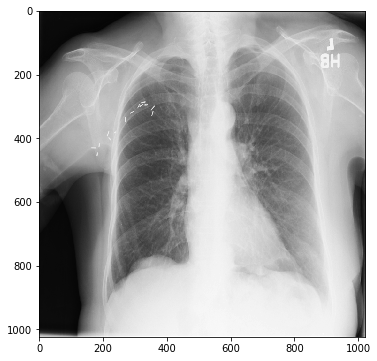

Correct Labels: Hernia
Predicted Labels: Infiltration


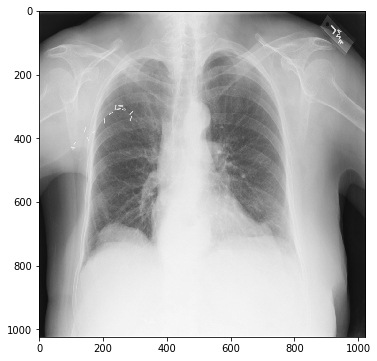

Correct Labels: Hernia
Predicted Labels: Hernia, Infiltration


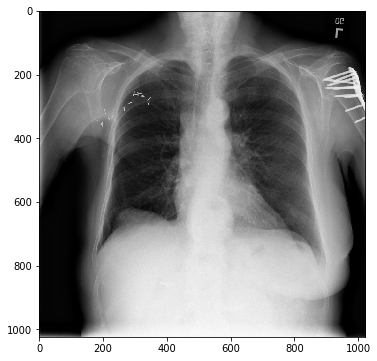

Correct Labels: Pleural_Thickening
Predicted Labels: Infiltration, Pneumothorax


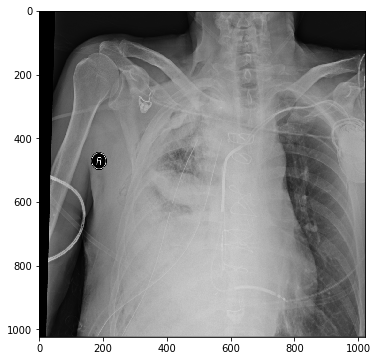

Correct Labels: Effusion, Pneumothorax, Pneumonia
Predicted Labels: Effusion, Infiltration, Pneumothorax


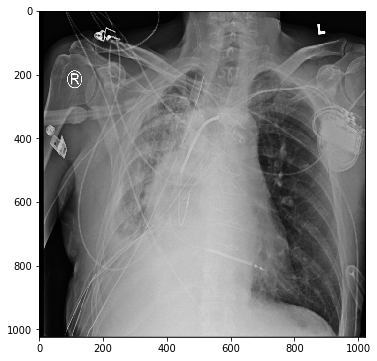

Correct Labels: Effusion
Predicted Labels: Effusion


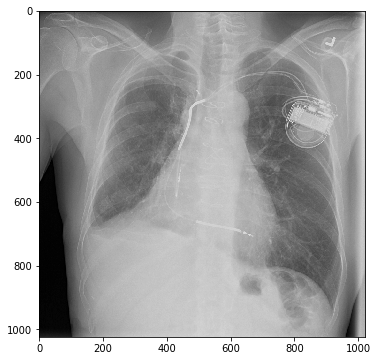

Correct Labels: Infiltration, Mass, Pneumothorax
Predicted Labels: Atelectasis


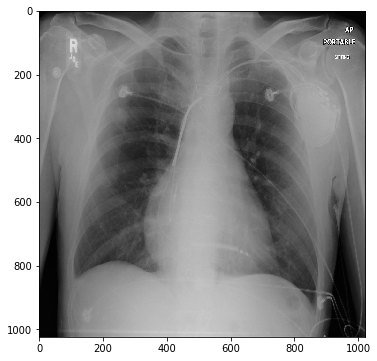

Correct Labels: Cardiomegaly, Infiltration, Mass, Nodule
Predicted Labels: Effusion


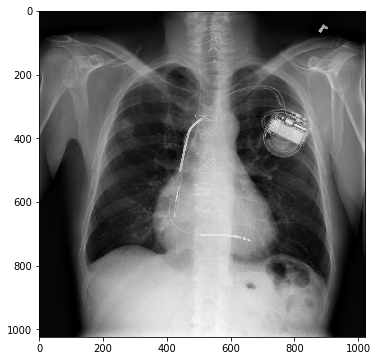

Correct Labels: Cardiomegaly
Predicted Labels: Infiltration


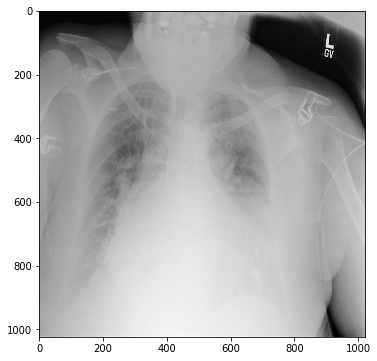

Correct Labels: Cardiomegaly, Effusion, Edema
Predicted Labels: Infiltration


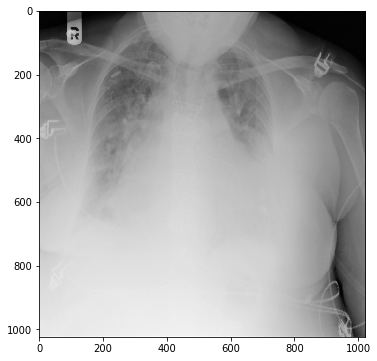

Correct Labels: Infiltration
Predicted Labels: Effusion, Infiltration


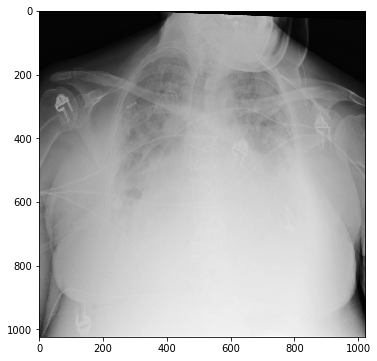

Correct Labels: Edema
Predicted Labels: Infiltration


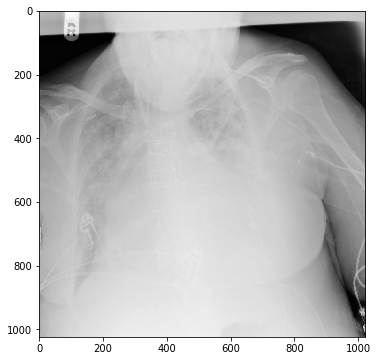

Correct Labels: Cardiomegaly, Infiltration
Predicted Labels: Infiltration


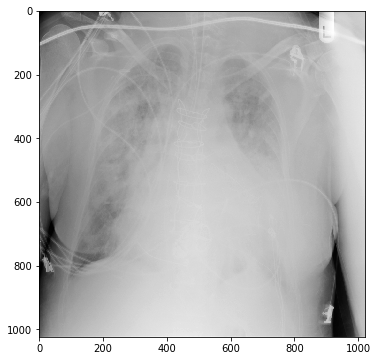

Correct Labels: Cardiomegaly, Effusion, Infiltration, Edema
Predicted Labels: Infiltration


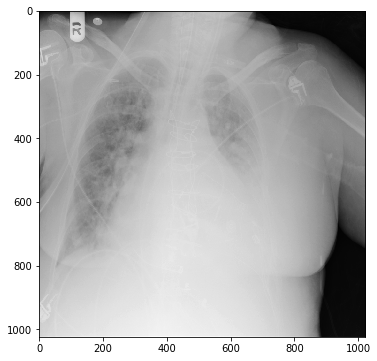

Correct Labels: Effusion, Infiltration, Atelectasis, Edema
Predicted Labels: Infiltration, Atelectasis


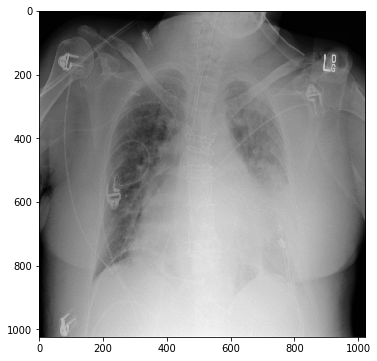

Correct Labels: Edema, Consolidation
Predicted Labels: Effusion, Infiltration


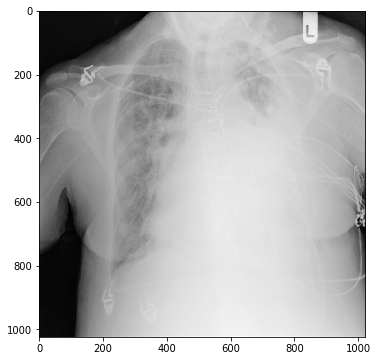

Correct Labels: Infiltration, Atelectasis, Edema
Predicted Labels: Infiltration, Atelectasis


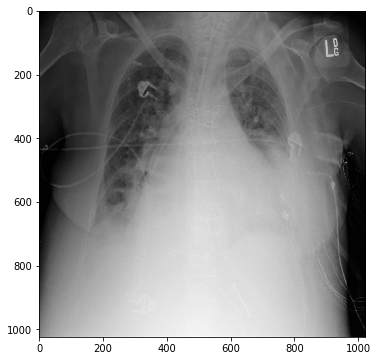

Correct Labels: Cardiomegaly
Predicted Labels: Infiltration


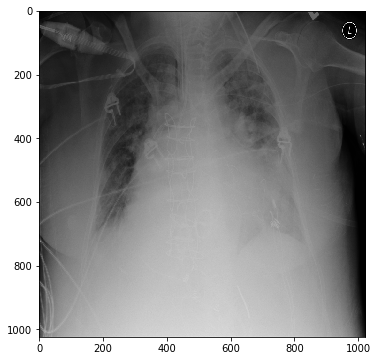

Correct Labels: Atelectasis
Predicted Labels: Infiltration


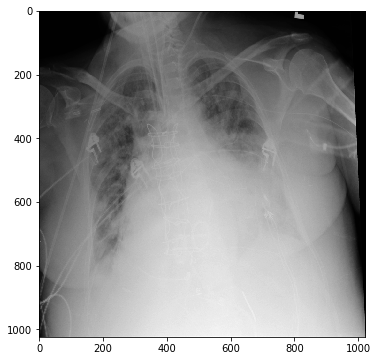

Correct Labels: Effusion, Fibrosis
Predicted Labels: Infiltration


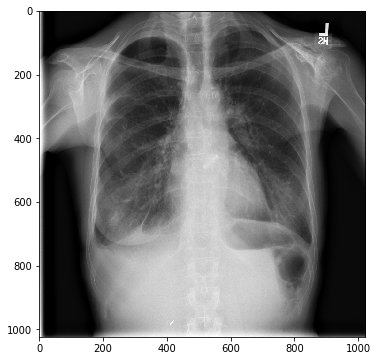

Correct Labels: Effusion
Predicted Labels: Effusion, Mass


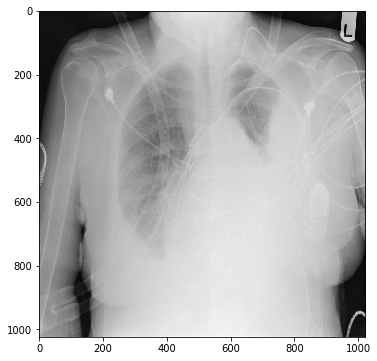

Correct Labels: Effusion, Infiltration
Predicted Labels: Effusion, Infiltration


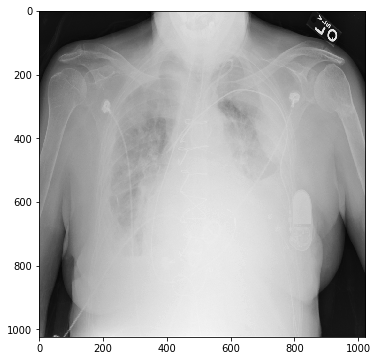

Correct Labels: Effusion, Infiltration
Predicted Labels: Effusion, Infiltration


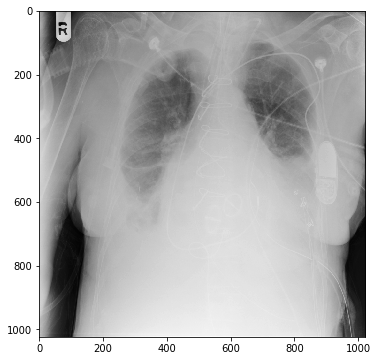

Correct Labels: Infiltration
Predicted Labels: Infiltration


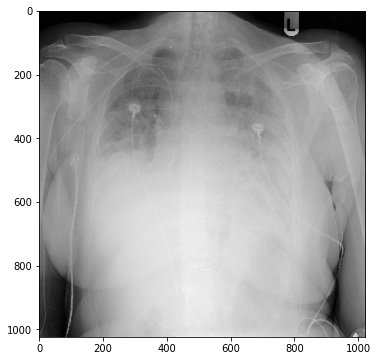

Correct Labels: Infiltration
Predicted Labels: Infiltration


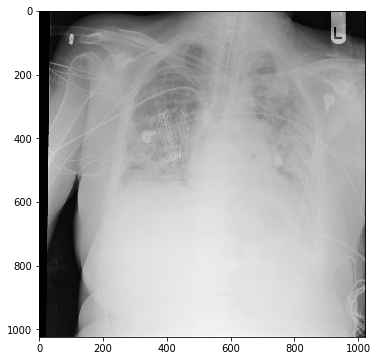

Correct Labels: Infiltration
Predicted Labels: Infiltration


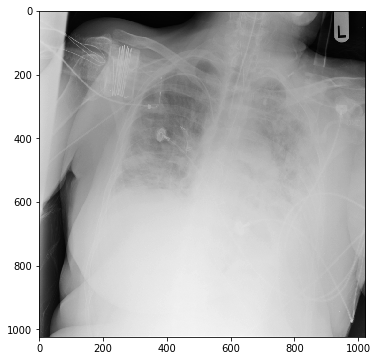

Correct Labels: Infiltration, Atelectasis
Predicted Labels: Infiltration, Atelectasis


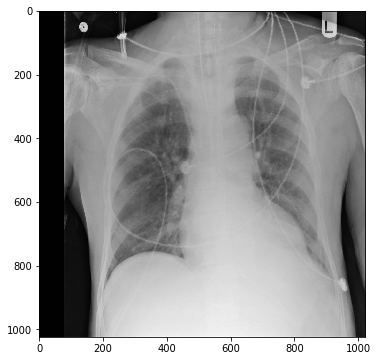

Correct Labels: Effusion
Predicted Labels: Effusion


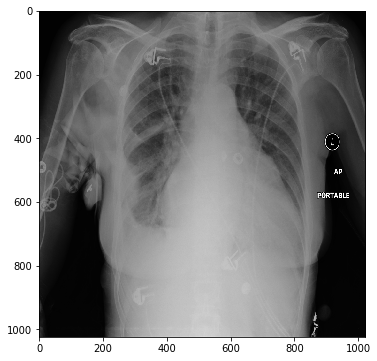

Correct Labels: Infiltration
Predicted Labels: Infiltration


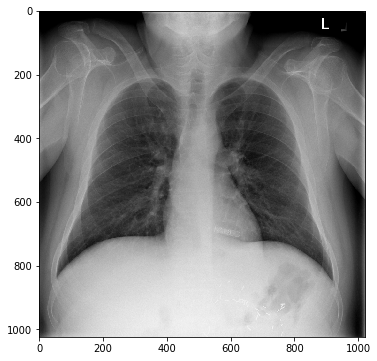

Correct Labels: Effusion, Infiltration
Predicted Labels: Effusion, Infiltration


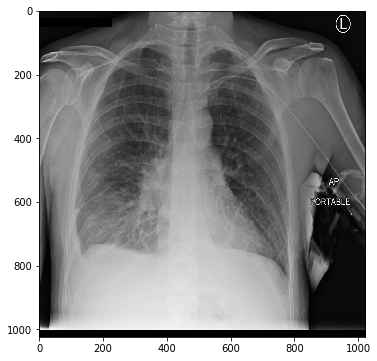

Correct Labels: Infiltration
Predicted Labels: Infiltration


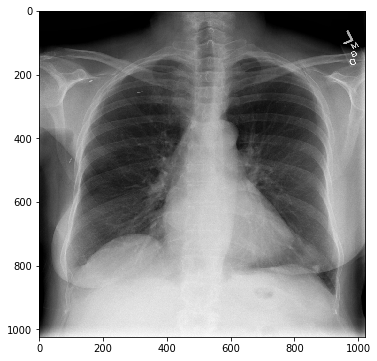

Correct Labels: Cardiomegaly, Infiltration
Predicted Labels: Cardiomegaly, Infiltration


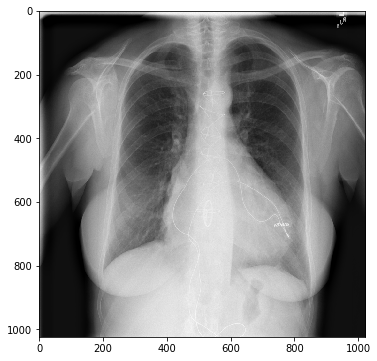

Correct Labels: Infiltration
Predicted Labels: Infiltration


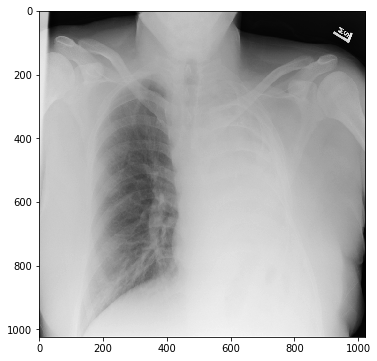

Correct Labels: Effusion, Infiltration
Predicted Labels: Effusion, Infiltration


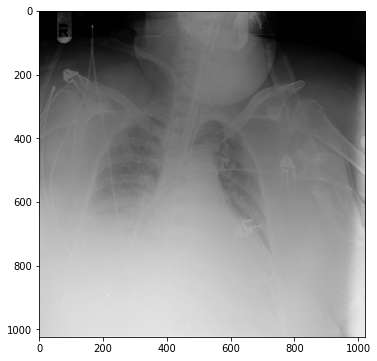

Correct Labels: Infiltration, Pneumothorax
Predicted Labels: Infiltration, Pneumothorax


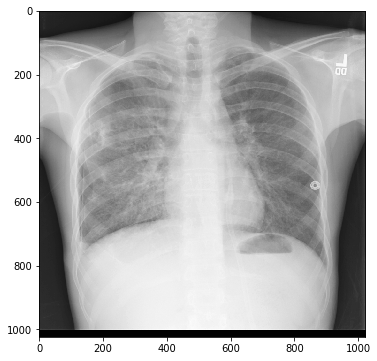

Correct Labels: Infiltration
Predicted Labels: Infiltration


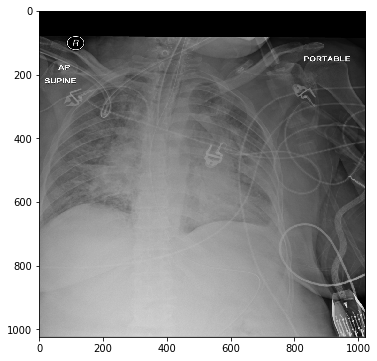

Correct Labels: Emphysema
Predicted Labels: Emphysema


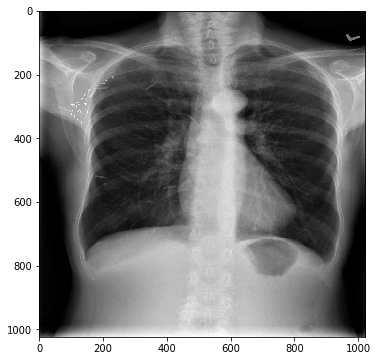

Correct Labels: Infiltration
Predicted Labels: Infiltration


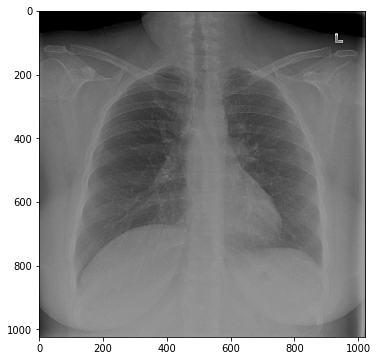

Correct Labels: Infiltration
Predicted Labels: Infiltration


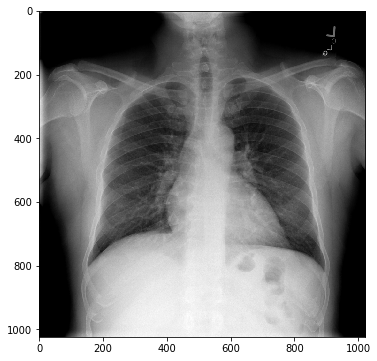

Correct Labels: Infiltration
Predicted Labels: Infiltration


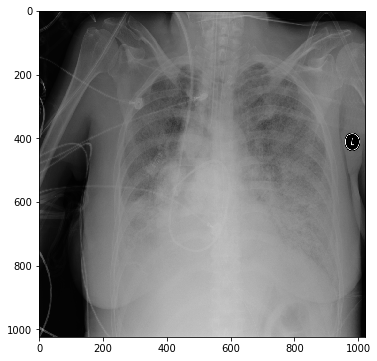

In [42]:
get_images(model_4)